In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.nn.init as init
import itertools
import copy
from tqdm import tqdm
import statistics
import pandas as pd
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import io
import sys


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU")

GPU is available. Using Tesla T4


# Load data and split in the multi agent system


In [3]:
#Set up main parameters
num_agents = 10
batch_size = 32
test_batch_size = 64

In [4]:
# def load_mnist(train_subset_size=15000, test_subset_size=500):
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.5,), (0.5,))
#     ])

#     train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
#     test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#     train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
#     test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)

#     train_subset = Subset(train_dataset, train_indices)
#     test_subset = Subset(test_dataset, test_indices)

#     return train_subset, test_subset

def load_cifar10():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset


def load_fashion():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset


def load_svhn():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                                download=True, transform=transform)
    return train_dataset, test_dataset


def load_mnist():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset


def split_dataset_heterogeneously(dataset, num_agents, alpha=.8):
    np.random.seed(42)
    num_samples = len(dataset)
    indices = np.random.permutation(num_samples)
    # Generate Dirichlet distribution for each agent
    proportions = np.random.dirichlet(np.repeat(alpha, num_agents), size=1)[0]
    # Calculate the number of samples for each agent
    agent_sizes = (proportions * num_samples).astype(int)
    # Adjust to ensure all samples are allocated
    agent_sizes[-1] = num_samples - np.sum(agent_sizes[:-1])

    agent_splits = []
    start_idx = 0
    for size in agent_sizes:
        end_idx = start_idx + size
        agent_indices = indices[start_idx:end_idx]
        agent_subset = Subset(dataset, agent_indices.tolist())
        agent_splits.append(agent_subset)
        start_idx = end_idx

    return agent_splits, proportions

def create_dataloaders(train_splits, val_splits, test_set, batch_size=32, test_batch_size=32):
    train_loaders = []
    val_loaders = []
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

    for train_data, val_data in zip(train_splits, val_splits):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    return train_loaders, val_loaders, test_loader

def imshow(img):
    img = img / 2 + 0.5  # unnormalize if necessary
    npimg = img.numpy()

    # Check if the image has 1 channel (grayscale)
    if npimg.shape[0] == 1:
        plt.imshow(npimg[0], cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


def import_dataLoaders(data, num_agents=10, batch_size=32, test_batch_size=64, plot = True):
  if data == 'MNIST':
    train_dataset, test_dataset = load_mnist()
  elif data=='FASHION':
    train_dataset, test_dataset = load_fashion()
  elif data=='SVHN':
    train_dataset, test_dataset = load_svhn()
  # Split train dataset into train and validation sets
  train_size = int(0.8 * len(train_dataset))
  val_size = len(train_dataset) - train_size
  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  # Split train and validation sets heterogeneously among agents
  train_splits, train_proportions = split_dataset_heterogeneously(train_dataset, num_agents)
  val_splits, val_proportions = split_dataset_heterogeneously(val_dataset, num_agents)
  # Create dataloaders for each agent
  train_loaders, val_loaders, test_loader = create_dataloaders(train_splits, val_splits, test_dataset, batch_size, test_batch_size)
  # Print and plot the first batch of the first agent
  dataiter = iter(train_loaders[0])
  images, labels = dataiter.__next__()
  print("First batch of the first agent:")
  print(f"  Images shape: {images.shape}")
  print(f"  Labels: {labels}")
  # Plot the images
  if plot ==True:
    imshow(torchvision.utils.make_grid(images))
  # Verify the size of the test loader
  print(f"Test loader batch size: {test_loader.batch_size}")
  #display distribution of data volumes in the system
  if plot==True:
    agents = [f'Agent {i}' for i in range(num_agents)]
    plt.bar(agents, train_proportions)
    plt.xlabel('Agents')
    plt.ylabel('Proportion of data')
    plt.title('Data Allocation by Dirichlet Distribution')
    plt.show()
  return train_loaders, val_loaders, test_loader


# Create Graph Topology

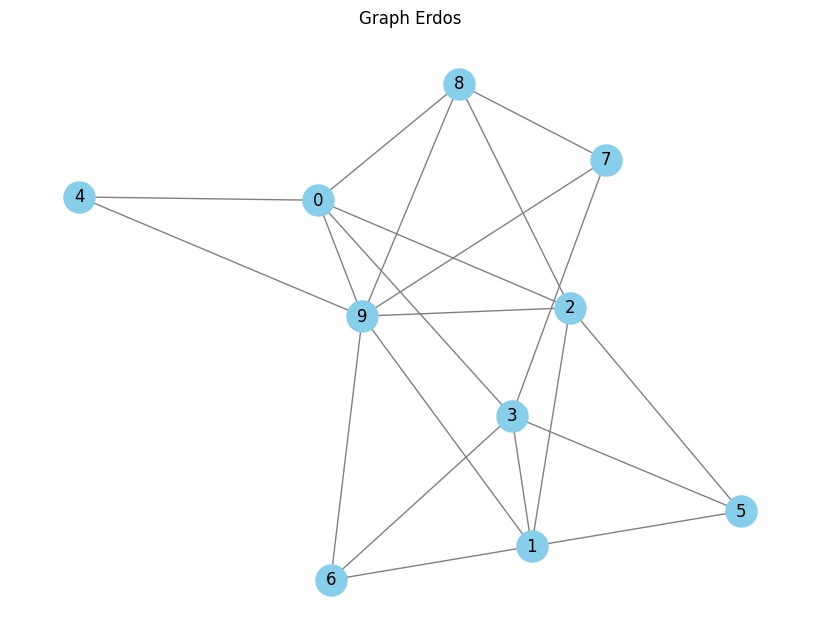

In [5]:
def genera_grafo_connesso(tipo_grafo, num_nodi, prob=None, m=None, seed=None):
    while True:
        if tipo_grafo == 'erdos':
            if prob is None:
                raise ValueError("Per un grafo di Erdos-Renyi, specificare la probabilità 'prob'")
            G = nx.erdos_renyi_graph(num_nodi, prob, seed=seed)
        elif tipo_grafo == 'scale_free':
            if m is None:
                raise ValueError("Per un grafo scale-free, specificare il numero di archi 'm'")
            G = nx.barabasi_albert_graph(num_nodi, m, seed=seed)
        else:
            raise ValueError("Tipo di grafo non supportato. Scegliere tra 'erdos_renyi' o 'scale_free'")

        # Controlla se il grafo è connesso
        if nx.is_connected(G):
            break

    adj_matrix = nx.adjacency_matrix(G).todense()
    laplacian_matrix = nx.laplacian_matrix(G).todense()

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(f"Graph {tipo_grafo.replace('_', ' ').title()}")
    plt.show()
    return adj_matrix, laplacian_matrix, G

type_g = 'erdos'
p = 0.5
Adj_matrix, L, G = genera_grafo_connesso(type_g, num_agents, prob=p, seed=42)
# print("Matrice di adiacenza:\n", A)
# print("Laplaciano:\n", L

# Define learning function at the edge of the network

In [6]:
# # def set_random_seed(seed):
# #     torch.manual_seed(seed)
# #     torch.cuda.manual_seed_all(seed)  # GPU
# #     random.seed(seed)

# class Net(nn.Module):
#     def __init__(self, input_channels=images.shape[1], num_classes=10):
#         super(Net, self).__init__()
#         #set_random_seed(seed)

#         self.conv1 = nn.Conv2d(images.shape[1], 8, kernel_size=5)
#         self.fc1 = nn.Linear(8 * 24 * 24, 32)  # Adjust input size for fully connected layer
#         self.fc2 = nn.Linear(32, num_classes)

#         # Initialize weights
#         self._initialize_weights()

#     def forward(self, x):
#         x = F.gelu(self.conv1(x))  # Using GELU activation function
#         x = x.view(-1, 8 * 24 * 24)
#         x = F.gelu(self.fc1(x))
#         x = self.fc2(x)            # Output layer
#         return x

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)


class Net(nn.Module):
    def __init__(self, dataset='CIFAR', num_classes=10):
        super(Net, self).__init__()
        if dataset == 'MNIST' or dataset == 'FASHION':
            self.input_channels = 1  # 1 channel (grayscale)
            self.input_size = 28  # Images are 28x28
        else:  # CIFAR-10
            self.input_channels = 3  # CIFAR-10 has 3 channels (RGB)
            self.input_size = 32  # CIFAR-10 images are 32x32
        self.conv1 = nn.Conv2d(self.input_channels, 8, kernel_size=5)

        # Compute output size after convolution
        # New size = input_size - kernel_size + 1
        self.conv_output_size = self.input_size - 5 + 1
        # Fully connected layers
        self.fc1 = nn.Linear(8 * self.conv_output_size * self.conv_output_size, 32)  # Flatten conv output
        self.fc2 = nn.Linear(32, num_classes)  # Output layer
        self._initialize_weights()

    def forward(self, x):
        # Apply the first convolutional layer and GELU activation
        x = F.gelu(self.conv1(x))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 8 * self.conv_output_size * self.conv_output_size)
        # Fully connected layers with GELU activation
        x = F.gelu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # Xavier initialization for Conv2d and Linear layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


# Define Successive Convex Approximation routine:
$$ min_{\omega} U(\omega) = F(\omega)+G(\omega) \\
U_i(x) = f_i(\omega_i,x_i) + \sum_{j=1}^I f_j(\omega_i,x_j) + G(\omega_i) ; i=\{1,..,N\}$$
Where $G(\omega)$ is a convex regularized defined as $||\omega_i||^2$.
- The surrogate function for *full linearization* (FL) of the initial possibly non convex cost function is defined as a proximal gradient procedure: $$\tilde{f_i}(x_i|x_i[n])= f_i(x_i[n]) + \nabla f_i(x_i[n])(x_i - x_i[n]) + \frac{\tau}{2}||x_i - x_i[n] ||$$
That solved in closed form produces:
$$\nabla_{x} \tilde{F}(x^k|x_i[n])=0 \\
\nabla_{x}F(x_i[n]) + \tau(x^k-x_i[n])=0 \\
x^{k+1}= x^k - \frac{1}{\tau} \nabla F(x_i[n])$$

- Best Response map aims to approximate for each agent $i^{th}$:
$$ \hat{\omega_i}(\omega_i[n]) = argmin_{x\omega_i[n] \in K} \tilde{f_i}(\omega_i|\omega_i[n]) + (\omega_i-\omega_i[n]) \sum_{j \neq i} ^N \nabla_x f_j(\omega_i[n]) $$

- Convex smooth combination:
$$ \omega_i[n+1] = \omega_i [n] + \gamma^k(\hat{\omega_i}(\omega_i[n])-\omega_i [n]) $$

The main idea is to develop a gradient tracking method to implement a fully distributed framework where $\sum_{j \neq i} ^N \nabla_{\omega_i} f_j(\omega_i[n])$, that is not distributed since anget $i$ need the knowledge of all $j^{}th$ agents gadients; \
Furthermore, the use of dynamic consensus to update the
 objective functions of users' subproblems is a novel idea
 (introduced for the first time in "NEXT-Di Lorenzo & Scutari"), which makes the proposed scheme convergent even in the case of nonconvex
 $F$'s (as in the case of multi-agent systems).


# Bio-Inspired in-Network succEssive conveX approximaTion (NEXT)

  **Initialization:**  
  $ \omega_i[0] \in \mathcal{K}, y_i[0] = \nabla f_i[0], \tilde{\pi}_i[0] = Iy_i[0] - \nabla f_i[0], \forall i = \{1, \dots, N\} $  
  $ W_{ij} = I  -\epsilon L   \ \ \ with  \epsilon < \frac{2}{\lambda_{max} L}$

  ---

  (S.1)  If $  \|\hat{\omega}(\omega^k) - \omega^k\| < tolerance $ : STOP;

  ---

  (S.2) *Local SCA optimization*:  
  Each agent $i^{th}: $

  (a) Computes locally $ \tilde{\omega}_i[n]:  
  \tilde{x}_i[n] = \text{argmin}_{\omega_i \in \mathcal{K}} \tilde{U}_i (\omega_i; \omega_i[n], \tilde{\pi}_i[n])  $

  (b) Updates its local variable $ : z_i[n] = \omega_i[n] + \alpha[n] (\tilde{\omega}_i[n] - \omega_i[n])
  $

  ---
  (S.3) *Consensus update*:  
  Defining $g(y)= c_a -c_b [exp\frac{-||y||^2}{\sigma} ]$ \\
  Each agent $i^{th}: $ collects data from its current neighbors and updates  $\omega_i[n], y_i[n], \tilde{\pi}_i[n] $:

  (a)  
  $
  \omega_i[n + 1] = \sum_{j=1}^{N} W_{ij}[n] z_j[n] g(z_i[n]-z_j[n])
  $  

  (b)  
  $
  y_i[n + 1] = \sum_{j=1}^{I} W_{ij}[n] y_j[n] + (\nabla f_i[n + 1] - \nabla f_i[n])$  

  (c)  
  $
  \tilde{\pi}_i[n + 1] = N \cdot y_i[n + 1] - \nabla f_i[n + 1]
  $

  ---

  (S.4) $ n \leftarrow n + 1 $, and go to (S.1).


In [95]:
def flatten_param(model, input=None):  # Highlight that you need to pass the
                                       # client class and their model (agents.models) as input!
    flattened_params = []
    if input == None:
      for n,p in model.items():
        flattened_params.append(p.view(-1))
    elif input == "model":
      for param in model.parameters():
        flattened_params.append(param.view(-1))  # Flatten the parameter and add to list

    flattened_vector = torch.cat(flattened_params)  # Concatenate all flattened parameters into a single vector 1D
    return flattened_vector

def get_subset_loader(train_loader, fraction):
    # Convert the DataLoader into a list of batches
    all_batches = list(train_loader)
    # Determine how many batches to use in base of validation accuracy
    num_batches_to_use = int(len(all_batches) * fraction)

    # Randomly select the batches you want to use
    selected_batches = random.sample(all_batches, num_batches_to_use)

    return selected_batches

def get_diffusion(Laplacian):
    eigv, _ = torch.linalg.eig(torch.tensor(Laplacian,  dtype=torch.float32))
    eps = np.random.uniform(0, (2/torch.max(eigv.real).item()))
    #eps = (2/torch.max(eigv.real).item())/100
    #print(f"Learning rate is equal to {round(eps,8)}")
    W = torch.eye(num_agents) - eps * Laplacian
    return W, eps

#Define attraction repulsion function
def g(x, z, pie, input=None):
    y = (flatten_param(x, input))-(flatten_param(z,input))
    return pie[0]-pie[1]*(-torch.norm(y, p=2)/pie[2])

def reshape_flattened_gradients(flattened_gradients, model):
    reshaped_gradients = {}
    pointer = 0
    for name, param in model.named_parameters():
        param_shape = param.shape
        param_size = param.numel()  # Total number of elements in the parameter tensor
        # Extract the portion of flattened gradients corresponding to this parameter
        reshaped_grad = flattened_gradients[pointer:pointer + param_size].view(param_shape)
       # Store the reshaped gradient in the dictionary
        reshaped_gradients[name] = reshaped_grad.clone().detach()
        # Move the pointer to the next set of gradients
        pointer += param_size
    return reshaped_gradients

# Agents class for federated learning
class Agents:
    def __init__(self, train_loaders, val_loaders, test_loader, L, num_agents, pie=[], dataset='MNIST', tau = None, epochs=10, gamma_zero = None, iterations = None, symmetry=True, lr=0.1, reg_lambda=.001):
        self.K = iterations
        self.sum_diff_history=[]
        self.L = L
        self.reg_lambda = reg_lambda
        self.stopping_iter = None
        self.pie = pie
        self.train_loaders = train_loaders
        self.val_loaders = val_loaders
        self.test_loader = test_loader
        self.num_agents = num_agents
        self.epochs = epochs
        self.W, self.learning_rate = get_diffusion(self.L)[0], get_diffusion(self.L)[1]
        self.gamma_values =[gamma_zero] #gamma[0]< 1/eps
        self.models = [Net(dataset=dataset).to(device) for _ in range(num_agents)]
        self.optimizers = [optim.SGD(model.parameters(), lr= lr ) for model in self.models]
        self.criterion = nn.CrossEntropyLoss()
        self.validation_accuracies = {i: 1 for i in range(num_agents)}  # Dictionary to store validation accuracies
        self.losses = {i: [] for i in range(num_agents)}  # Dictionary to store losses
        self.previous_response = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ] #store parameters initializations and previous weights iteratively
        self.actual_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        # Initialize Y[0], Z[0], pie_tilde[0] as lists of dictionaries
        self.Y = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.pie_tilde = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.Z = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.next_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.stopping_condition = []



    #FedAVG functions-----------------------------------------------------------
    def train_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        optimizer = self.optimizers[agent_idx]
        train_loader = self.train_loaders[agent_idx]
        val_loader = self.val_loaders[agent_idx]
        model.train()

        for epoch in range(1):
          running_loss = 0.0
          for inputs, labels in train_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()
                  running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        self.losses[agent_idx].append(avg_loss)
        self.validate_agent(agent_idx)

    def FedAvg(self):
        # Initialize zeros parameters to store weighted ones
        for i in range(self.num_agents):
          upd_state_dict = {}
          for n, p in self.models[0].state_dict().items():
              upd_state_dict[n] = torch.zeros_like(p)
          # Perform the aggregation process
          for j in range(self.num_agents):
              for n, p in self.models[j].state_dict().items():
                  upd_state_dict[n] += p
          for n in upd_state_dict:
                  upd_state_dict[n] /= self.num_agents #perform average of parameters
              # Load the updated weights into the i^th agent's model
          #self.models[i].load_state_dict(upd_state_dict)
        for j in range(self.num_agents):
          self.models[j].load_state_dict(upd_state_dict)

        #print("Federated avg process has finished;")

    def train_FedAvg(self):
      for round in  tqdm(range(self.epochs)):
        for agent_idx in range(self.num_agents):
            self.train_agent(agent_idx)
        self.FedAvg()

    #---------------------------------------------------------------------------


    def check_convergence(self, k, tolerance=1e-3):
        converged = True
        sum_diff=0
        i_agent = flatten_param(self.models[0], input="model")
        for j_agent in range(self.num_agents):
          if j_agent !=0:
           sum_diff += torch.sum(i_agent - flatten_param(self.models[j_agent], input="model"))
        avg_diff = torch.abs(sum_diff / (self.num_agents) )
        self.sum_diff_history.append(avg_diff.cpu().item())
        #print(f" \n Average params difference equal to {avg_diff}")
        if torch.abs(avg_diff) >= tolerance:
          converged = False
        if converged==True:
          print(f" \n Average params difference equal to {avg_diff}")
          print(f"Convergence reached in {k+10} iterations.")
          self.stopping_iter = k
        return converged


    def aggr_process(self):
        for i in range(self.num_agents):
              upd_state_dict = {}
              # Initialize zeros parameters to store weighted ones
              for n, p in self.models[i].state_dict().items():
                  upd_state_dict[n] = torch.zeros_like(p)

              # Perform the aggregation process
              for j in range(self.num_agents):
                  for n, p in self.models[j].state_dict().items():
                      # Convert agents.W[i, j] to the same type as p
                      w = self.W[i, j].type(p.dtype)
                      bio_g = g(self.models[i],self.models[j],self.pie, input="model").type(p.dtype)
                      # print(f"agent {i,j} coeff = {bio_g}")
                      upd_state_dict[n] += (w * bio_g )*p
                  #print(f"agent {i,j} coeff = {bio_g}")


              # Load the updated weights into the i^th agent's model
              self.models[i].load_state_dict(upd_state_dict)



    def gamma_update(self, epsilon=0.8): #updating step size rule
        gamma_next = self.gamma_values[-1]*(1-(epsilon*self.gamma_values[-1])) #gamma[0] < 1/eps and eps in (0,1])
        self.gamma_values.append(gamma_next)

    # def upd_diffusion(self): #Update non symmetric diffusion matrix
    #     Upd_w = torch.tensor(list(self.validation_accuracies.values()))*self.W
    #     M = np.array(Upd_w, dtype=float)
    #     row_sums = M.sum(axis=1)
    #     row_sums[row_sums == 0] = 1 #avoid division by zero by setting row sums that are zero to one (this is a really bas case)
    #     normalized_matrix = M / row_sums[:, np.newaxis]
    #     #check stochasticity condition
    #     ones_vector = np.ones(M.shape[0])
    #     result = np.dot(normalized_matrix, ones_vector)
    #     if np.allclose(result, ones_vector)== False:
    #       print("Diffusion matrix do not respect stochasticity conditions")
    #     self.W = torch.tensor(normalized_matrix)

    def upd_diffusion(self):  # Update double stochastic diffusion matrix
        # Update weights based on validation accuracies
        Upd_w = torch.tensor(list(self.validation_accuracies.values())) * self.W
        M = np.array(Upd_w, dtype=float)

        # Step 1: Avoid division by zero in row sums by replacing zero sums with 1
        row_sums = M.sum(axis=1)
        row_sums[row_sums == 0] = 1
        M = M / row_sums[:, np.newaxis]  # Normalize rows

        # Step 2: Implement the Knopp algorithm for double stochasticity
        # Initializing scaling factors for rows and columns
        r = np.ones(M.shape[0])  # Row scaling factors
        c = np.ones(M.shape[1])  # Column scaling factors

        # Iteratively update scaling factors until convergence
        for _ in range(200):  # prevent infinite loops
            r = 1.0 / M.dot(c)  # Update row scaling
            c = 1.0 / M.T.dot(r)  # Update column scaling

        # Apply the scaling factors to achieve double stochasticity
        double_stochastic_matrix = np.diag(r).dot(M).dot(np.diag(c))

        # Step 3: Validate double stochasticity conditions
        ones_vector = np.ones(double_stochastic_matrix.shape[0])
        row_check = np.allclose(double_stochastic_matrix.sum(axis=1), ones_vector)
        col_check = np.allclose(double_stochastic_matrix.sum(axis=0), ones_vector)

        if not (row_check and col_check):
            print("Diffusion matrix does not respect double stochasticity conditions")

        # Update the diffusion matrix
        self.W = torch.tensor(double_stochastic_matrix)

    #---------------------------------------------------------------------------

    def validate_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        val_loader = self.val_loaders[agent_idx]
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #print(f'Agent {agent_idx} Validation Accuracy: { (correct / total)}')
        self.validation_accuracies[agent_idx]=correct / total


    def plot_losses(self):
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
      plt.grid()
      for agent_idx in range(self.num_agents):
          axes[0].plot(self.losses[agent_idx], label=f'Agent {agent_idx}', linestyle='-', marker='^')
      axes[0].set_xlabel('Epochs')
      axes[0].set_ylabel('Loss')
      axes[0].set_ylim(0, 2.5)#max(self.losses)+0.5)
      axes[0].set_title('NEXT System Loss behaviour')
      axes[0].legend()

      for k in range(len(self.stopping_condition)):
          axes[1].plot(self.stopping_condition, linestyle='-', marker='^')
      axes[1].set_xlabel('Iteration')
      axes[1].set_ylabel('1/n ∑|| x̂(x[n])-x[n] ||')
      axes[1].set_ylim(0,max(self.stopping_condition)+0.25)
      axes[1].set_title('SCA Avg stopping condition over iterations')

      plt.tight_layout()
      plt.show()


    def plot_disagreement(self,plot=False):
        if plot==True:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(self.sum_diff_history)), self.sum_diff_history, marker='o', linestyle='-')
            plt.xlabel('Iteration')
            plt.xlim(0,25)
            plt.ylabel('Total Disagreement')
            plt.title('Consensus among agents')
            plt.grid()
            plt.show()
        return self.sum_diff_history




    def initialize_agents(self,dataset):
        """
        Initialize agents' models and variables.
        """

        wk = Net(dataset=dataset).to(device).state_dict()
        for i in range(self.num_agents):
            #wk = Net().to(device).state_dict()
            self.previous_response[i] = wk #store feasible initializations
            #w_previous = self.models[i].state_dict().to(device)
            w_previous = copy.deepcopy(self.models[i].state_dict())
            # Initialize model parameters to wk
            for name, param in self.models[i].named_parameters():
                if name in wk:
                    param.data = wk[name].clone()
            self.models[i].train()
            optimizer = self.optimizers[i]
            #Compute difference among current iterate and previous response variable (x_i - x[n])
            difference = [(w_prev-wk) for (n1,w_prev),(n2,wk) in zip(w_previous.items(), self.models[i].state_dict().items())] #computye and flat difference among w_prev and wk
            difference_flatten = torch.cat([diff.view(-1) for diff in difference])
            all_batch_gradients = []
            for inputs, labels in self.train_loaders[i]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.models[i](inputs)
                loss = self.criterion(outputs, labels)
                optimizer.zero_grad()
                gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                pie_flatten = torch.cat([grad.view(-1) for grad in gradients]).to(device)
                all_batch_gradients.append(pie_flatten.clone().detach())  #initialize y_i[k] as ∇f_i[0]
                # Surrogate loss
                loss_surrogate = loss.clone().detach().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten)
                loss_surrogate.backward()
                optimizer.step()
            # Update Z
            # for name, param in self.Z[i].items():
            #     self.Z[i][name] += w_previous[name] + ( self.gamma_values[-1] * (w_previous[name] - wk[name]) )
            # Update Y[0]= ∇f_i(w_i[0])
            self.Y[i] = torch.mean(torch.stack(all_batch_gradients), dim=0).to(device) #gradients mean of batches (not of agents!)
            self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents) - torch.mean(torch.stack(all_batch_gradients), dim=0)
            #self.gamma_update()
#-------------------------------------------------------------------------------
    def run_iterations(self, tolerance = None, symmetry=True):
        """
        Run K iterations of the NEXT algorithm.
        Step 1: Local Updates leveraging SCA optimization
                Convex smooth with diminishing gamma step size rule
        Step 2: Consensus Step to update model paramters
        Step 3: Local Variables Updates
        """

        diff = {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}

        for k in tqdm(range(self.epochs),desc= "Processing NEXT training with neighborhood"):
            # Step 1
            stopping_avg = []
            for i in range(self.num_agents):

                optimizer = self.optimizers[i]
                wk = copy.deepcopy(self.models[i].state_dict()) #run this after initialization menas that agent model
                                                                #already have feasible initialization of model parameters
                #print(f"at the beginnin : \n {wk}")
                all_batch_gradients = []
                #Run the surrogate optimization and update parameters with best response map procedure
                #BEST RESPONSE MAP
                #-----------------
                #selected_batches = get_subset_loader(self.train_loaders[i], round(self.validation_accuracies[i],1))
                #print(f"Fraction of data choosed by val_acc is {self.validation_accuracies[i]} for agent {i}")
                #----------------
                running_loss = 0.0
                for inputs, labels in self.train_loaders[i]:
                #for inputs, labels in selected_batches:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    loss = self.criterion(outputs, labels)
                    optimizer.zero_grad()
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    pie_flatten = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(pie_flatten.clone().detach())
                    # Surrogate loss
                    difference_flatten = flatten_param(self.models[i], input="model") - ( torch.cat([p.view(-1) for n,p in self.previous_response[i].items()])  )
                    #print(difference_flatten)
                    l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss_surrogate = loss.clone().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten).requires_grad_(True) + (self.reg_lambda*l2_norm) #convex regularizer
                    # print(torch.matmul(pie_flatten, difference_flatten))
                    running_loss += loss_surrogate.item()
                    loss_surrogate.backward()
                    optimizer.step() #best response map update x_hat
                #print(f"After optimiation \n {self.models[i].state_dict()}")

                #Validate agent to break diffusion matrix symmetry
                self.validate_agent(i)
                # Update Z as the convex combination (smooth)
                stopping = 0  # Reset stopping for each agent
                for name, p in self.Z[i].items():
                    self.Z[i][name] = wk[name] +  torch.mul( (self.models[i].state_dict()[name] - wk[name]), self.gamma_values[-1] )
                    stopping += torch.linalg.vector_norm(self.models[i].state_dict()[name] - wk[name])
                stopping_avg.append(stopping)
                #print(f"stopping: {stopping} for agent {i}")

                self.actual_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #store loss function
                avg_loss = running_loss / len(self.train_loaders[i])
                self.losses[i].append(avg_loss)

            stop = sum(stopping_avg) / self.num_agents #track the mean of the stopping conditions of the system
            self.stopping_condition.append(stop.cpu().numpy())

            # Step 2: Consensus Step to update model params
            for i in range(self.num_agents):
                updated_state_dict = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                grads_passing = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                for j in range(self.num_agents):
                  for (name1, w_i), (name2, z_i) in zip(updated_state_dict.items(), self.Z[j].items()):
                    g_bio = g(self.Z[i], self.Z[j], self.pie).type(z_i.dtype)
                    updated_state_dict[name1] +=torch.mul( z_i, g_bio) * self.W[i][j]  # Accumulate contributions from each j with attraction-repulsion function

                # Load updated state dict
                self.models[i].load_state_dict(updated_state_dict)
                self.previous_response[i] = updated_state_dict #load the consensus based update in the previous
                                                               # response variable;
                # Compute next gradients
                all_batch_gradients = []
                for inputs, labels in self.train_loaders[i]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss = self.criterion(outputs, labels) + l2_norm
                    optimizer = self.optimizers[i]
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    next_grad_flat = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(next_grad_flat)
                self.next_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #next_grads.append(torch.mean(torch.stack(all_batch_gradients), dim=0))
                # Update y_i[k+1]
                grads_diff = self.next_grads[i] - self.actual_grads[i]
                grads_diff_resh = reshape_flattened_gradients(grads_diff, self.models[i])

                for j in range(self.num_agents):
                    if j != i:
                      y_j = reshape_flattened_gradients( self.Y[j], self.models[0]  ) #reshape in original paramters nn size
                      for name,p in y_j.items():
                        grads_passing[name] += p*self.W[i][j] #Accumulate contributions from each j^th agent
                for  (n1, consensus),(n2, diff) in zip(grads_passing.items(), grads_diff_resh.items()):
                    grads_passing[n1] = consensus + diff
                self.Y[i] = torch.cat([grad.view(-1) for n,grad in grads_passing.items()])
                # Update pie_tilde
                self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents ) - self.next_grads[i]

            #check convergence--------------------------------------------------
            converged = self.check_convergence(k)
            if converged ==True:
              print()
              break

            # Update gamma and diffusion matrix
            self.gamma_update()
            if symmetry==False:
               self.upd_diffusion()
            #print(self.W)
            #print(f"Validation Accuracies: {self.validation_accuracies}")
            #refresh gradients variables
            self.actual_grads = self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]
            self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]

        for iter in range(self.K -10):
            self.aggr_process()
            converged = self.check_convergence(iter, tolerance)
            if converged == True:
              break



    def NEXT_train(self, dataset, symmetry, tolerance=1e-4, plot=True):
        """
        Execute the full SCA training process.
        """
        self.initialize_agents(dataset)
        self.run_iterations(tolerance, symmetry)
        if plot ==True:
          self.plot_losses()


    def test_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        test_loader = self.test_loader
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        print(f'Agent {agent_idx}  Test Accuracy: {round(test_accuracy * 100, 2)}% ')

        return test_accuracy


# Results



##MNIST

First batch of the first agent:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels: tensor([9, 8, 5, 7, 1, 5, 0, 0, 1, 1, 7, 9, 3, 4, 7, 5, 1, 2, 1, 5, 2, 6, 1, 6,
        5, 1, 1, 3, 2, 5, 0, 7])


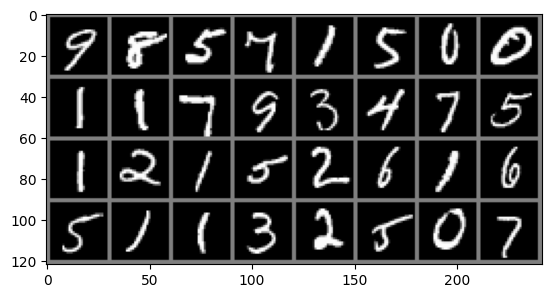

Test loader batch size: 64


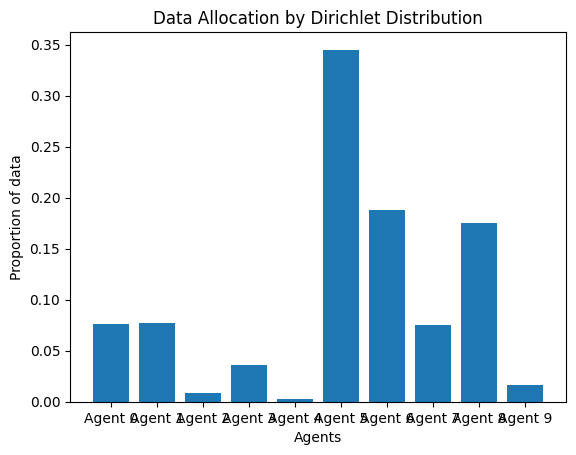

In [48]:
train_loaders, val_loaders, test_loader = import_dataLoaders('MNIST', plot=True)

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:51<00:00, 35.19s/it]


 
 Average params difference equal to 0.0009717922657728195
Convergence reached in 62 iterations.


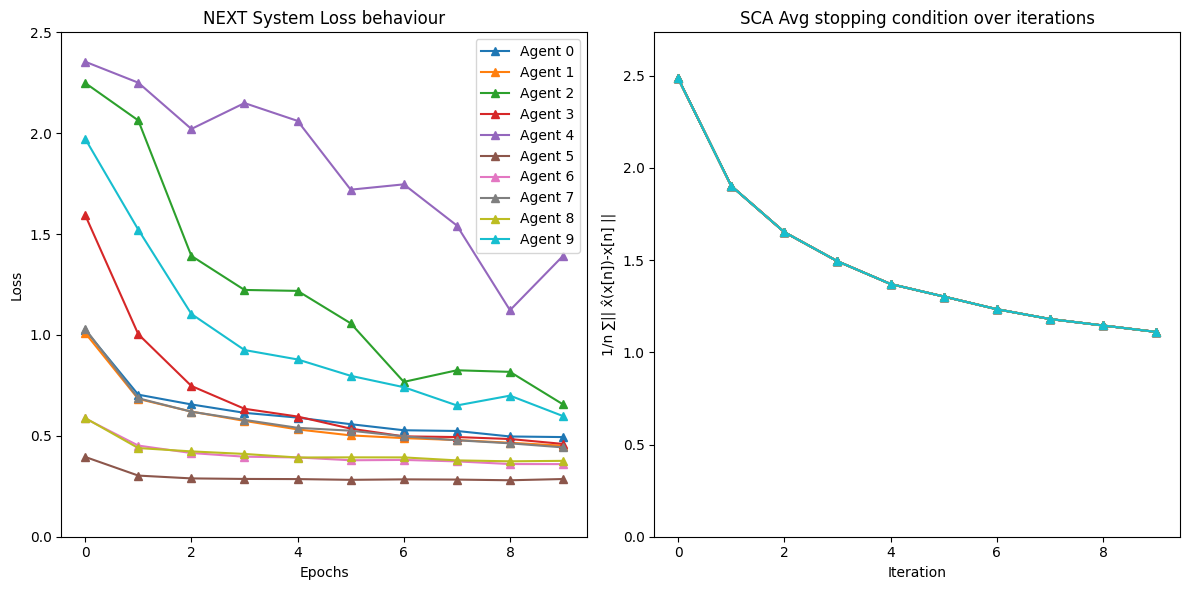

Agent 0  Test Accuracy: 91.6% 


In [78]:
torch.cuda.manual_seed(42)
torch.manual_seed
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=True)
MNIST_sym_acc = system.test_agent(0)
sym_stop = system.stopping_iter


In [80]:
mnist_sym_h= system.plot_disagreement(plot=False)

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:40<00:00, 34.02s/it]


 
 Average params difference equal to 0.0008658712613396347
Convergence reached in 37 iterations.


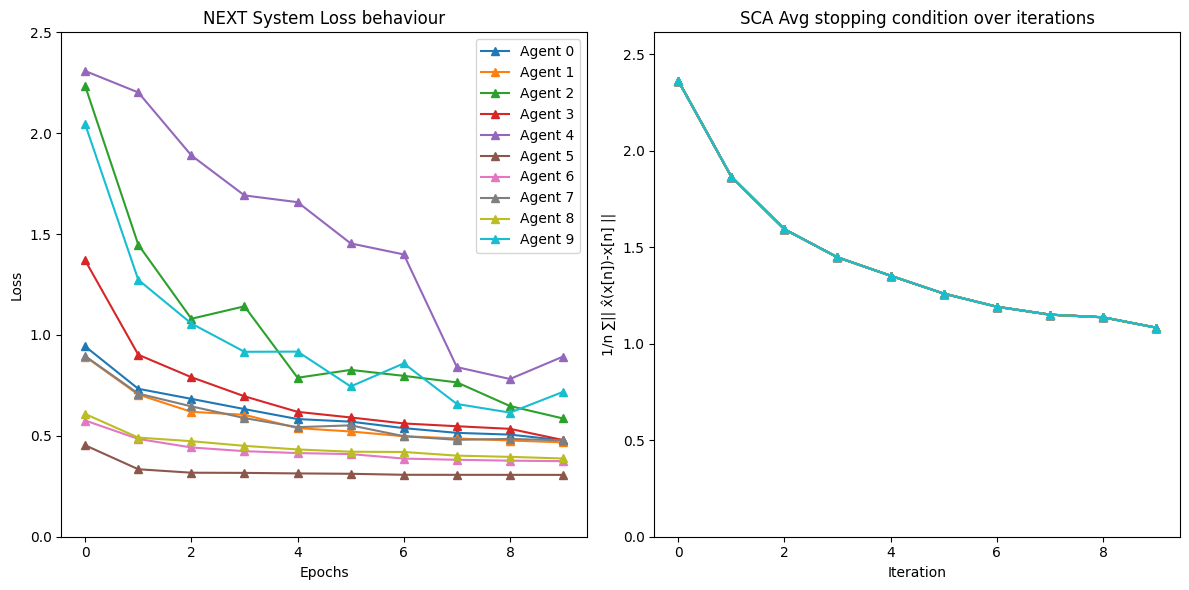

Agent 0  Test Accuracy: 92.3% 


In [81]:
torch.cuda.manual_seed(42)
torch.manual_seed
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs = 10, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset= 'MNIST',tolerance=1e-3, symmetry=False)
MNIST_Nsym_acc = system.test_agent(0)
sym_stop = system.stopping_iter


In [82]:
mnist_Nsym_h= system.plot_disagreement(plot=False)
np.savetxt("mnist_Nsym_h.txt", mnist_Nsym_h, delimiter=',')

In [92]:
pie_1_values = [1.0]
pie_2_values = np.linspace(0.0, 0.5, 5).tolist()
pie_3_values = [10]

torch.cuda.manual_seed(42)
# Use itertools.product to generate all combinations of these values
pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
best_acc = 0.0
best_pie=None
stop_bio=0

for pi in pie_grid:
  print(f"Evaluating params {pi}")
  system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, iterations = 100, pie = pi, gamma_zero = 0.5, symmetry=False, lr=0.01)
  system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=False, plot=False)
  test_acc = system.test_agent(0)
  bio_stop = system.stopping_iter
  mnist_bio_h = system.plot_disagreement(plot=False)

  if test_acc>best_acc:
    best_acc = test_acc
    best_pie = pi
    stop_bio = bio_stop
    best_bio_h= mnist_bio_h
print(f"Best pie is {best_pie} with accuracy {best_acc}")

Evaluating params (1.0, 0.0, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:36<00:00, 33.61s/it]


 
 Average params difference equal to 0.0006074257544241846
Convergence reached in 22 iterations.
Agent 0  Test Accuracy: 93.67% 
Evaluating params (1.0, 0.125, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:34<00:00, 33.45s/it]


 
 Average params difference equal to 0.0006784559809602797
Convergence reached in 20 iterations.
Agent 0  Test Accuracy: 93.21% 
Evaluating params (1.0, 0.25, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:38<00:00, 33.80s/it]


 
 Average params difference equal to 0.0007443714421242476
Convergence reached in 34 iterations.
Agent 0  Test Accuracy: 93.1% 
Evaluating params (1.0, 0.375, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:34<00:00, 33.42s/it]


 
 Average params difference equal to 0.0008414812618866563
Convergence reached in 46 iterations.
Agent 0  Test Accuracy: 93.17% 
Evaluating params (1.0, 0.5, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:36<00:00, 33.62s/it]


 
 Average params difference equal to 0.0009028964559547603
Convergence reached in 23 iterations.
Agent 0  Test Accuracy: 93.78% 
Best pie is (1.0, 0.5, 10) with accuracy 0.9378


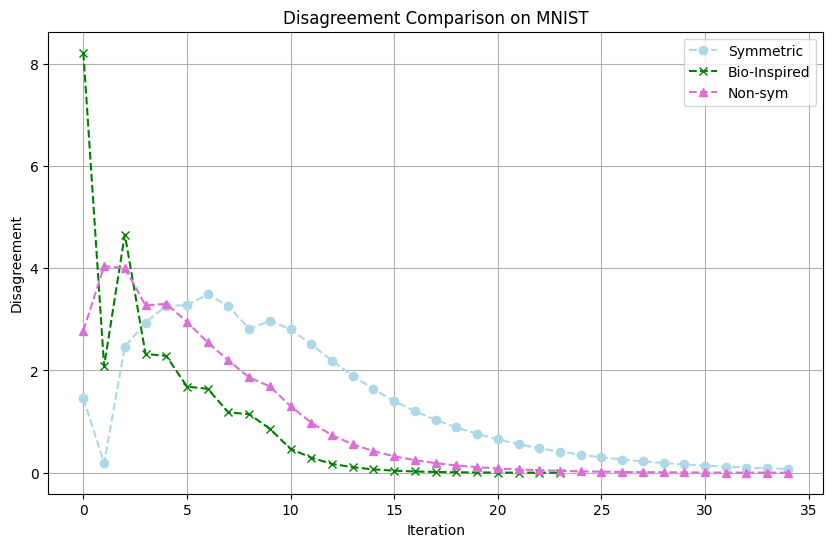

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(mnist_sym_h[:35], label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(best_bio_h[:35], label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.plot(mnist_Nsym_h[:35], label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on MNIST')
plt.grid()
plt.legend()
plt.show()

In [87]:
torch.cuda.manual_seed(42)
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.train_FedAvg()
Favg_acc = system.test_agent(0)

100%|██████████| 10/10 [02:53<00:00, 17.37s/it]


Agent 0  Test Accuracy: 92.65% 


In [ ]:
# # Save the variables to a text file
# with open("output.txt", "w") as file:
#     file.write(f"FedAvg_MNIST: {Favg_acc}\n")
#     file.write(f"symmetric_stopping_MNIST: {sym_stop}\n")
#     file.write(f"symmetric_accyracy_MNIST: {MNIST_sym_acc}\n")
#     file.write(f"non symmetric_stopping_MNIST: {Nsym_stop}\n")
#     # file.write(f"non symmetric_accyracy_MNIST: {MNIST_nonsym_acc}\n")
#     file.write(f"bio_stopping_MNIST: {stop_bio}\n")
#     file.write(f"bio_accyracy_MNIST: {best_acc}\n")

## FASHION MNIST

First batch of the first agent:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels: tensor([6, 8, 7, 2, 4, 7, 8, 0, 8, 9, 6, 7, 1, 8, 2, 3, 0, 8, 7, 5, 0, 6, 6, 0,
        3, 2, 1, 3, 1, 4, 9, 3])


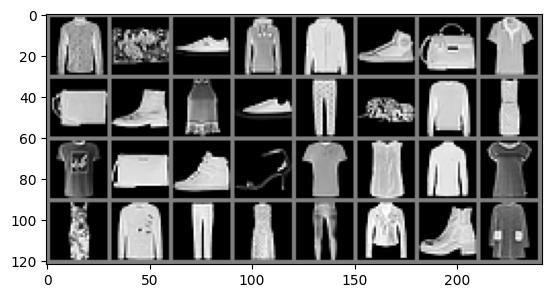

Test loader batch size: 64


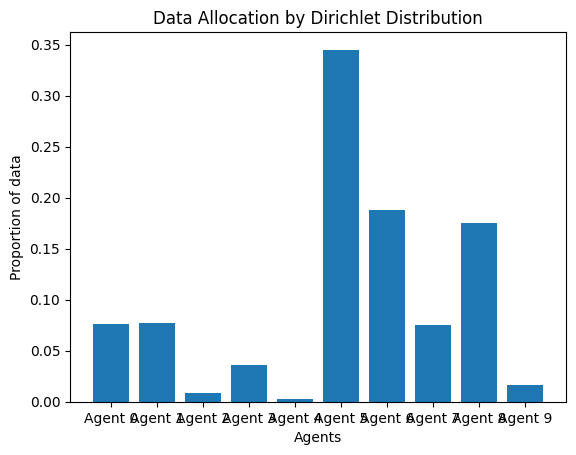

In [94]:
train_loaders, val_loaders, test_loader = import_dataLoaders('FASHION')

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [06:10<00:00, 37.06s/it]


 
 Average params difference equal to 0.000904861546587199
Convergence reached in 60 iterations.


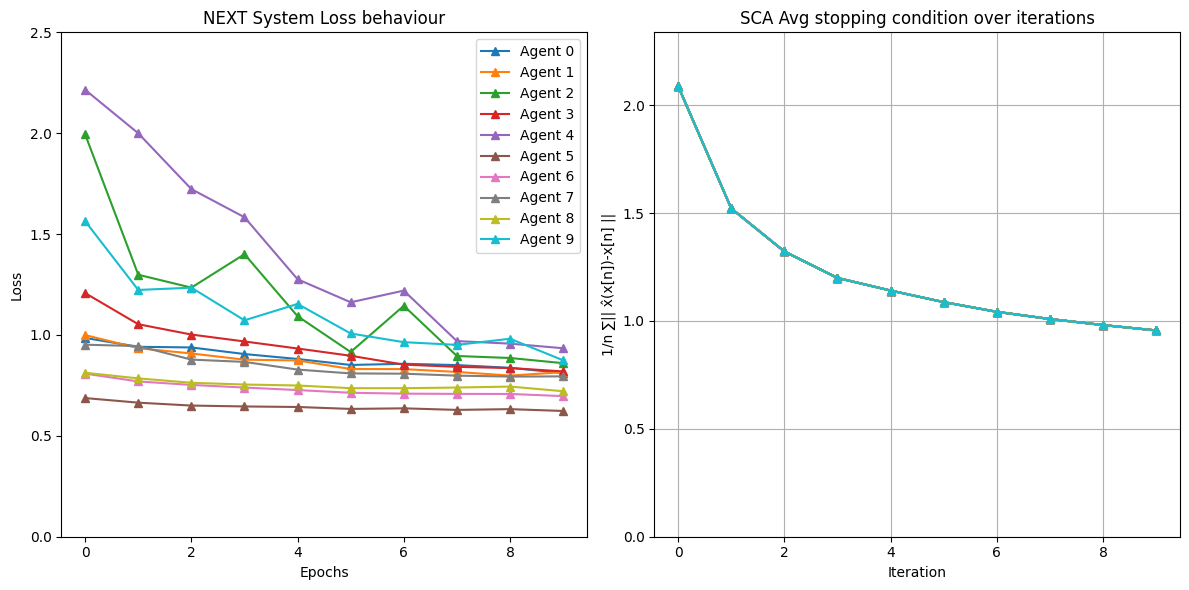

Agent 0  Test Accuracy: 79.45% 


In [96]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='MNIST', epochs=10, iterations = 150, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(dataset = 'MNIST', tolerance=1e-3, symmetry=True)
fashion_sym_acc = system.test_agent(0)
fashion_sym_stop = system.stopping_iter


In [97]:
fashion_sym_h= system.plot_disagreement(plot=False)

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:40<00:00, 34.02s/it]


 
 Average params difference equal to 0.0008909470634534955
Convergence reached in 27 iterations.


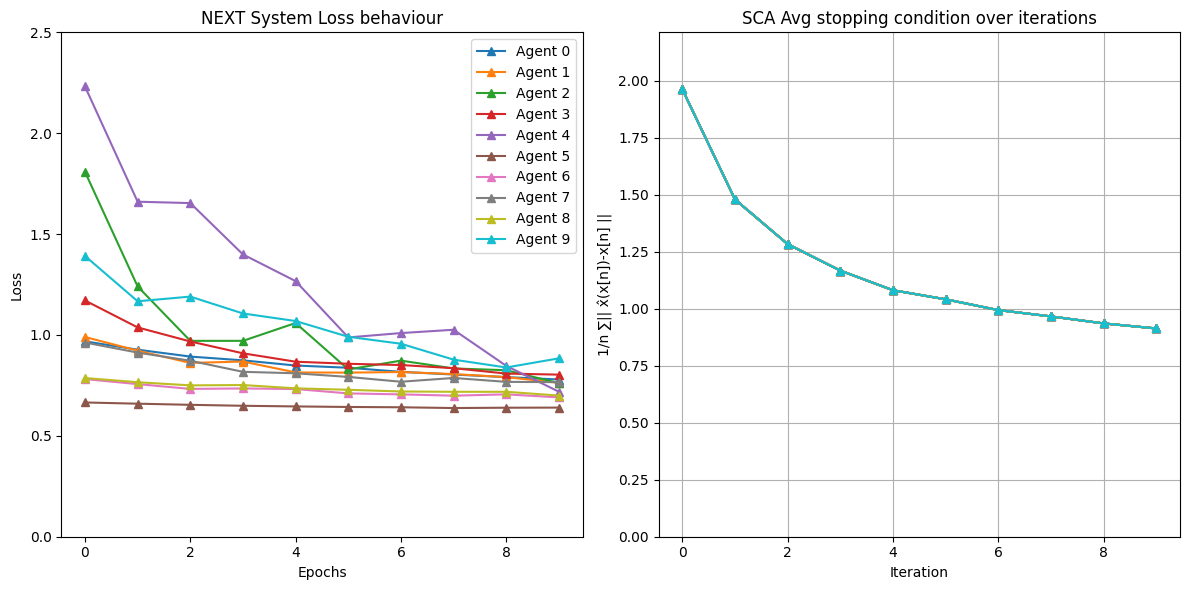

Agent 0  Test Accuracy: 80.02% 


In [98]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='FASHION', epochs=10, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset='FASHION',tolerance=1e-3, symmetry=False)
fashion_Nsym_acc = system.test_agent(0)
fashion_Nsym_stop = system.stopping_iter


In [99]:
fashion_Nsym_h= system.plot_disagreement(plot=False)


In [103]:
torch.cuda.manual_seed(42)
pie_1_values = [1.0]
pie_2_values = np.linspace(0.0, 0.5, 5).tolist()
pie_3_values = [10]

# Use itertools.product to generate all combinations of these values
pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
best_acc = 0.0
best_pie=None
fashion_stop_bio=0

for pi in pie_grid:
  print(f"Evaluating params {pi}")
  system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, iterations = 200, pie = pi, gamma_zero = 0.5, symmetry=False, lr=0.01)
  system.NEXT_train(dataset = 'FASHION', tolerance=1e-3, symmetry=False, plot=False)
  test_acc = system.test_agent(0)
  bio_stop = system.stopping_iter
  fashion_bio_h = system.plot_disagreement(plot=False)

  if test_acc> best_acc:
    fashion_bio_acc = test_acc
    best_pie = pi
    fashion_stop_bio = bio_stop
    fashion_best_h = fashion_bio_h
print(f"Best pie is {best_pie} with accuracy {fashion_bio_acc}")

Evaluating params (1.0, 0.0, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:33<00:00, 33.36s/it]


 
 Average params difference equal to 0.0009704488329589367
Convergence reached in 33 iterations.
Agent 0  Test Accuracy: 79.59% 
Evaluating params (1.0, 0.125, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:33<00:00, 33.37s/it]


 
 Average params difference equal to 0.0009081637836061418
Convergence reached in 30 iterations.
Agent 0  Test Accuracy: 80.89% 
Evaluating params (1.0, 0.25, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:34<00:00, 33.50s/it]


 
 Average params difference equal to 0.0007925977115519345
Convergence reached in 22 iterations.
Agent 0  Test Accuracy: 80.85% 
Evaluating params (1.0, 0.375, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:34<00:00, 33.41s/it]


 
 Average params difference equal to 0.0008914837962947786
Convergence reached in 61 iterations.
Agent 0  Test Accuracy: 80.13% 
Evaluating params (1.0, 0.5, 10)


Processing NEXT training with neighborhood: 100%|██████████| 10/10 [05:33<00:00, 33.31s/it]


 
 Average params difference equal to 0.0008799270144663751
Convergence reached in 22 iterations.
Agent 0  Test Accuracy: 80.23% 
Best pie is (1.0, 0.5, 10) with accuracy 0.8023


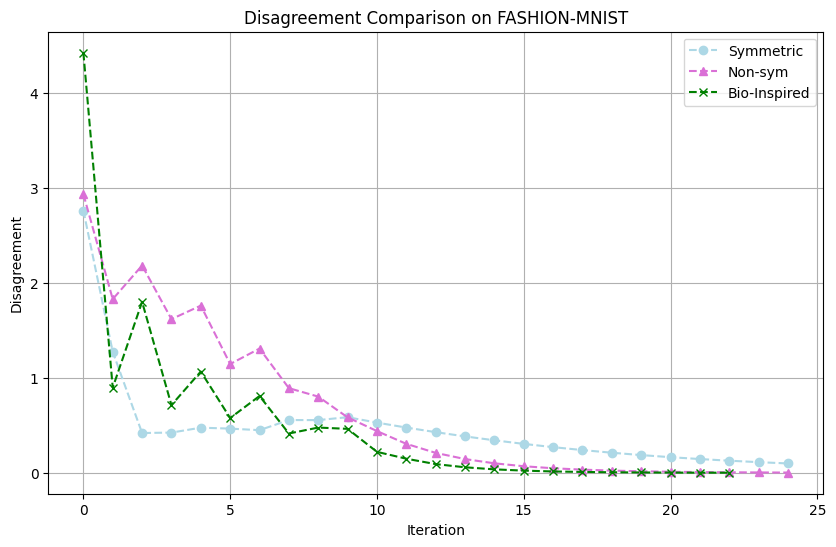

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(fashion_sym_h[:25], label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(fashion_Nsym_h[:25], label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.plot(fashion_best_h[:25], label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on FASHION-MNIST')
plt.grid()
plt.legend()
plt.show()

In [108]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, dataset='MNIST', gamma_zero = 0.5, symmetry=True, lr=0.01)
system.train_FedAvg()
fashion_Favg_acc = system.test_agent(0)

100%|██████████| 10/10 [02:29<00:00, 14.95s/it]


Agent 0  Test Accuracy: 79.54% 


In [ ]:
# Save the variables to a text file
with open("fashion_results_final.txt", "w") as file:
    file.write(f"Faveragin_cifar: {fashion_Favg_acc}\n")
    file.write(f"symmetric_stopping: {fashion_sym_stop}\n")
    file.write(f"symmetric_accyracy: {fashion_sym_acc}\n")
    file.write(f"non symmetric_stopping: {fashion_Nsym_stop}\n")
    file.write(f"non symmetric_accyracy: {fashion_Nsym_acc}\n")
    file.write(f"bio_stopping: {fashion_stop_bio}\n")
    file.write(f"bio_accyracy: {fashion_bio_acc}\n")

## SVHN Results

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
First batch of the first agent:
  Images shape: torch.Size([32, 3, 32, 32])
  Labels: tensor([8, 1, 1, 2, 3, 8, 2, 4, 1, 8, 1, 4, 5, 3, 1, 5, 1, 5, 2, 0, 5, 3, 3, 1,
        1, 1, 1, 5, 6, 4, 1, 2])


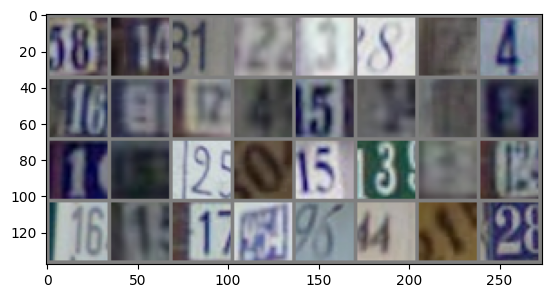

Test loader batch size: 64


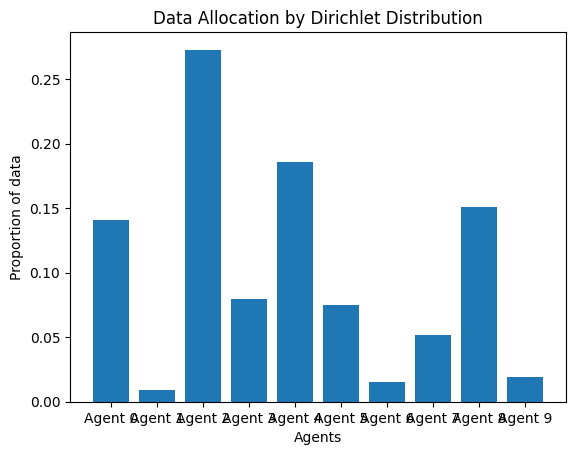

In [110]:
train_loaders, val_loaders, test_loader = import_dataLoaders('SVHN')

In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=10, iterations = 250, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=True)
svhn_sym_acc = system.test_agent(0)
svhn_sym_stop = system.stopping_iter


Processing NEXT training with neighborhood:  40%|████      | 4/10 [03:14<04:51, 48.53s/it]

In [ ]:
svhn_sym_h = system.plot_disagreement(plot=False)

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [08:12<00:00, 49.23s/it]


 
 Average params difference equal to 0.0009582025813870132
Convergence reached in 36 iterations.


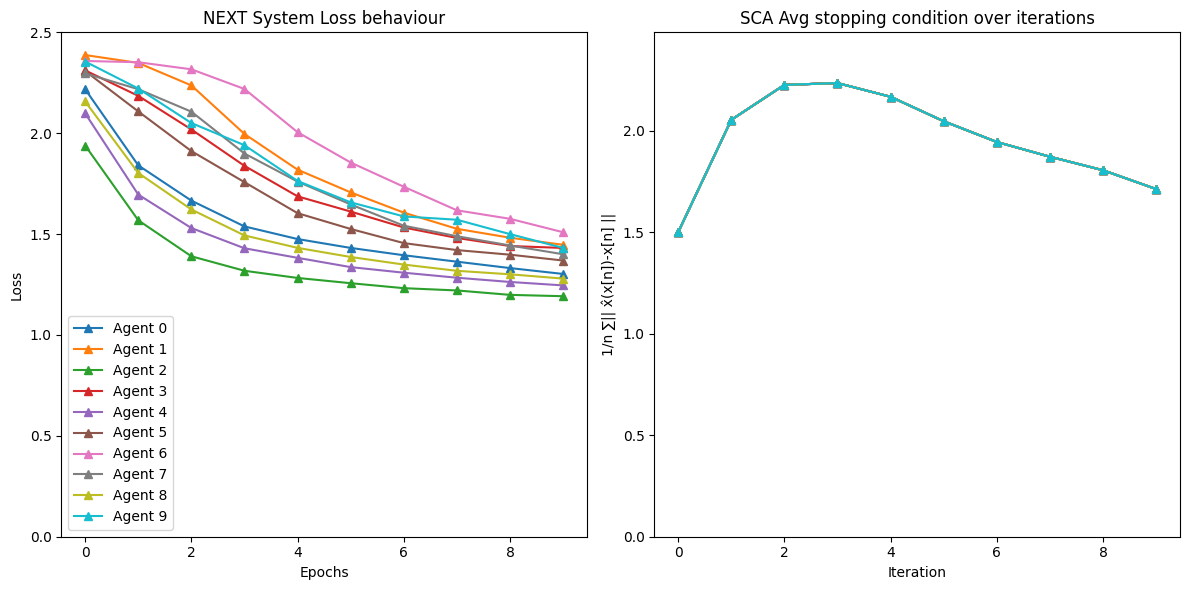

Agent 0  Test Accuracy: 65.18% 


In [36]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=10, iterations = 250, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=False)
svhn_Nsym_acc = system.test_agent(0)
svhn_Nsym_stop = system.stopping_iter
svhn_Nsym_h = system.plot_disagreement(plot=False)

In [39]:
svhn_Nsym_h= system.plot_disagreement(plot=False)
np.savetxt("svhn_Nsym_h.txt", svhn_Nsym_h, delimiter=',')

Processing NEXT training with neighborhood: 100%|██████████| 10/10 [08:20<00:00, 50.08s/it]


 
 Average params difference equal to 0.0009649698622524738
Convergence reached in 90 iterations.


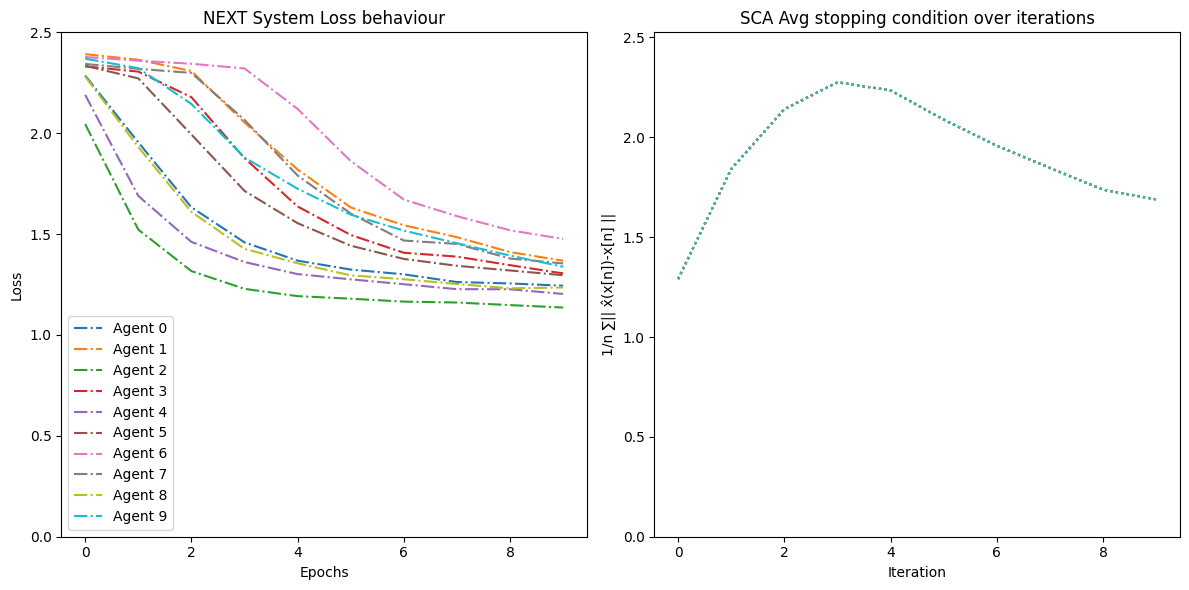

Agent 0  Test Accuracy: 67.48% 


In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=10, iterations = 250, pie = [1.0,0.5,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=False)
svhn_bio_acc = system.test_agent(0)
svhn_bio_stop = system.stopping_iter
svhn_bio_h = system.plot_disagreement(plot=False)

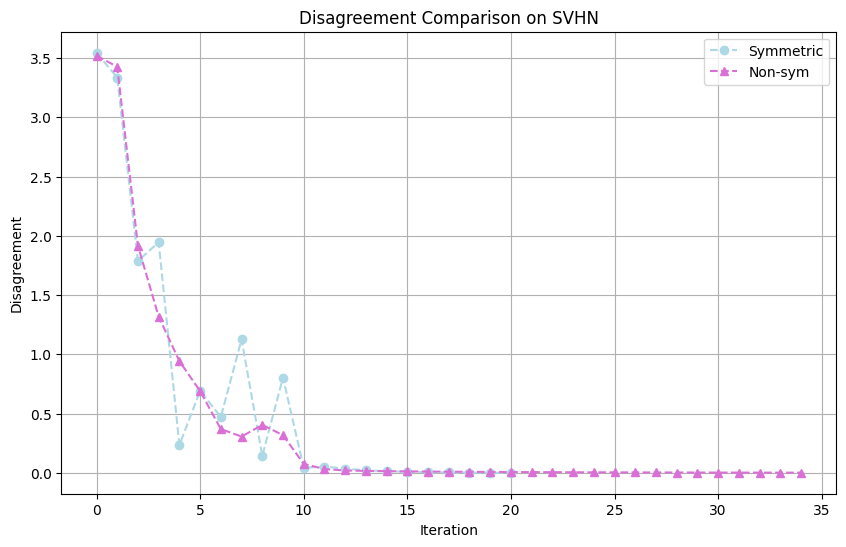

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(svhn_sym_h[:35], label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(svhn_bio_h[:35], label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.plot(svhn_Nsym_h[:35], label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on SVHN')
plt.grid()
plt.legend()
plt.show()

In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, dataset='SVHN', gamma_zero = 0.5, symmetry=True, lr=0.01)
system.train_FedAvg()
svhn_Favg_acc = system.test_agent(0)

100%|██████████| 10/10 [04:07<00:00, 24.76s/it]


Agent 0  Test Accuracy: 49.47% 


## CIFAR-10 RESULTS:


Processing NEXT training with neighborhood: 100%|██████████| 15/15 [08:12<00:00, 32.85s/it]


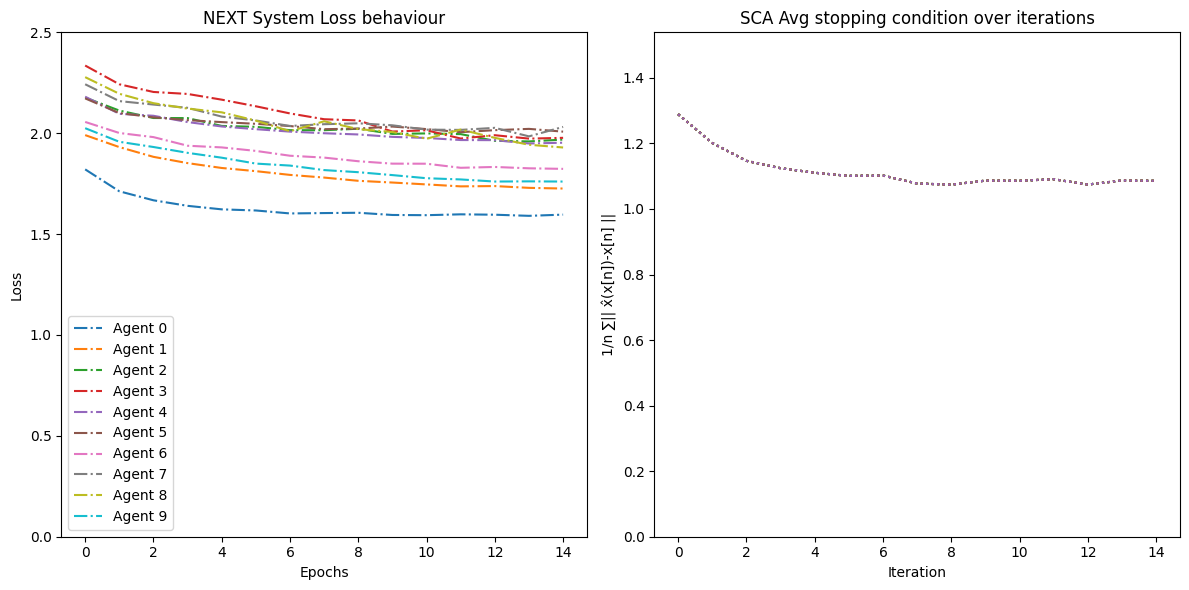

Agent 0  Test Accuracy: 38.88% 


In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='CIFAR', epochs=15, iterations = 1000, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(tolerance=1e-3, symmetry=True)
CIFAR_sym_acc = system.test_agent(0)
cifar_sym_stop = system.stopping_iter


Processing NEXT training with neighborhood: 100%|██████████| 15/15 [07:39<00:00, 30.64s/it]


 
 Average params difference equal to 0.0009699595393612981
Convergence reached in 38 iterations.


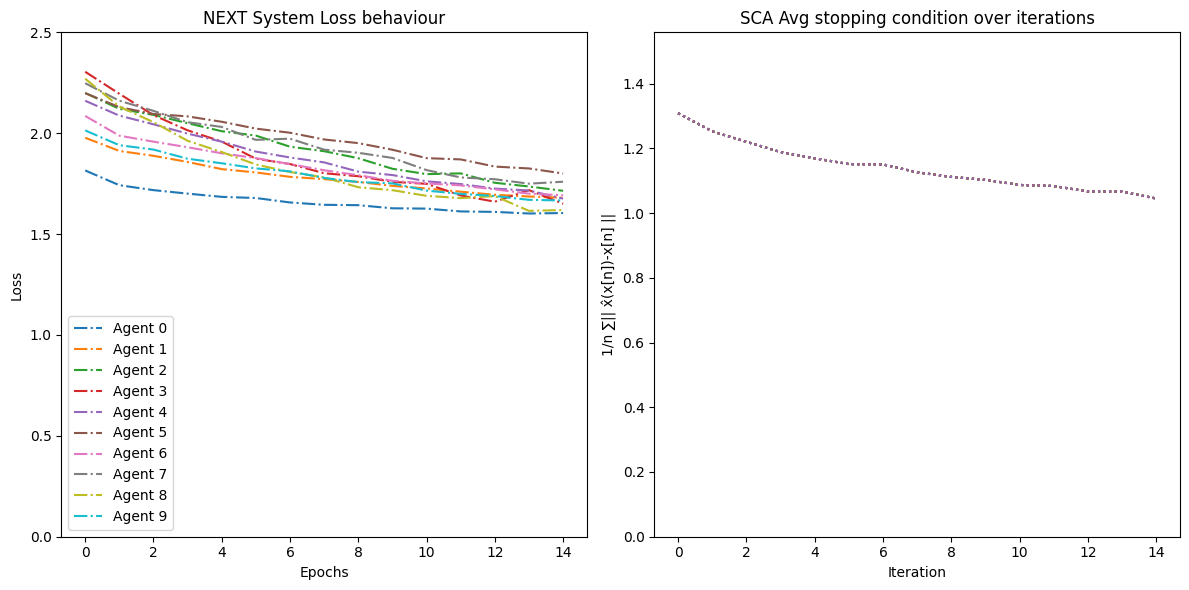

Agent 0  Test Accuracy: 48.05% 


In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='CIFAR', epochs=15, iterations = 1000, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(tolerance=1e-3, symmetry=False)
CIFAR_Nsym_acc = system.test_agent(0)
cifar_Nsym_stop = system.stopping_iter


In [ ]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='CIFAR', gamma_zero = 0.5, symmetry=True, lr=0.01)
system.train_FedAvg()
cifar_Favg_acc = system.test_agent(0)

100%|██████████| 10/10 [04:20<00:00, 26.03s/it]


Agent 0  Test Accuracy: 48.45% 


In [ ]:
# Save the variables to a text file
with open("output.txt", "w") as file:
    file.write(f"Faveragin_cifar: {cifar_Favg_acc}\n")
    file.write(f"symmetric_stopping: {cifar_sym_stop}\n")
    file.write(f"symmetric_accyracy: {CIFAR_sym_acc}\n")
    file.write(f"non symmetric_stopping: {cifar_Nsym_stop}\n")
    file.write(f"non symmetric_accyracy: {CIFAR_Nsym_acc}\n")

## Numerical Comparisons

In [ ]:
# df = pd.read_csv("results_frame.csv")

In [ ]:
import pandas as pd
N_Iter = [system.epochs, f"MNIST:{sym_stop}- F-MNIST:{fashion_sym_stop}- SVHN {svhn_sym_stop}" , f"MNIST:{Nsym_stop}- F-MNIST:{fashion_Nsym_stop}- SVHN {svhn_Nsym_stop}",  f"MNIST:{stop_bio}- F-MNIST:{fashion_stop_bio}- SVHN {svhn_bio_stop}"]
FASHION_Acc = [fashion_Favg_acc, fashion_sym_acc, fashion_Nsym_acc, fashion_bio_acc]
SVHN_Acc = [svhn_Favg_acc,svhn_sym_acc, svhn_Nsym_acc,svhn_bio_acc]

for i,res in enumerate(SVHN_Acc):
    SVHN_Acc[i] = round(res,4)
# Creating the DataFrame with the values from the image and provided variables
data = {
    'N_iterations': N_Iter,
    'MNIST': [0.9218, 0.9323, 0.9493, 0.9635],
    'F-MNIST': FASHION_Acc,  # Replace with actual values if known
    'SVHN': SVHN_Acc
}

# Index for the DataFrame
index = ['FedAvg', 'L-NEXT', 'Non-Sym. NEXT', 'Bio-NEXT']

#Creating the DataFrame
df = pd.DataFrame(data, index=index)
df


,Unnamed: 0,N_iterations,MNIST,Fashion-MNIST,SVHN
0,FedAvg,10,0.9218,0.8075,0.494737
1,L-NEXT,MNIST:40- F-MNIST:20- SVHN 11,0.9323,0.8081,0.562807
2,Non-Sym. NEXT,MNIST:20- F-MNIST:88- SVHN 57,0.9493,0.8169,0.671865
3,Bio-NEXT,MNIST:204- F-MNIST:66- SVHN 80,0.9635,0.8247,0.674785


In [ ]:
df.to_csv('results_frame.csv', index=True)

In [ ]:
N_Iter = [system.epochs, f"MNIST:{sym_stop+15}- F-MNIST:{fashion_sym_stop}" ,Nsym_stop+15, stop_bio]
MNIST_Acc = [Favg_acc, MNIST_sym_acc, MNIST_nonsym_acc, best_acc]
#CIFAR_Acc = [0,CIFAR_sym_acc,0,0]
FASHION_Acc = [fashion_Favg_acc, fashion_sym_acc, fashion_Nsym_acc, fashion_bio_acc]
import pandas as pd
df = pd.DataFrame({
    'N_iterations': N_Iter,
    'MNIST': MNIST_Acc ,
    'Fashion-MNIST': FASHION_Acc
    #'CIFAR-10': CIFAR_Acc
})
df.index = ['FedAvg', 'L-NEXT', 'Non-Sym. NEXT' ,'Bio-NEXT']
print(df)

               N_iterations   MNIST  CIFAR-10
FedAvg                   10  0.9218         0
L-NEXT                   40  0.9323         0
Non-Sym. NEXT            20  0.9493         0
Bio-NEXT                204  0.9635         0
